In [331]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Input locations

In [2]:
root = r'C:\Users\samantha.kuzma\OneDrive - World Resources Institute'

# - - - FOLDERS - - -  - - -  - - - #
# ReservoirWatch specific
data_root = os.path.join(root, "ReservoirWatch", "Data")
raw_path = os.path.join(data_root, "Raw")
analysis_path = os.path.join(data_root, "Analysis")

context_gdb = os.path.join(analysis_path, "contextual.gdb")
cwc_path = os.path.join(raw_path, "CWC")
# File that matches each reservoir to basins (containing, upstream, downstream)
res_ids_path = os.path.join(analysis_path, "reservoir_to_IDs_lookup.csv")


# Month lookup dictionary
month = {1: "Jan", 2: "Feb", 3: "March", 4: "April", 5: "May", 6: "June",
         7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}

# Output locations

In [327]:
julian_WL_range_folder = os.path.join(analysis_path, "Plots", "JulianDay_WaterLevels")
ts_WL_range_folder = os.path.join(analysis_path, "Plots", "Daily_WaterLevels")
trends_folder = os.path.join(analysis_path, "Plots", "Trends")

anomalies_path = os.path.join(analysis_path, 'reservoir_anomalies.csv')

# Functions

In [416]:
def find_anomalies(df_in, r):
    #define a list to accumlate anomalies
    data = df_in["Current Year Level (m)"].values
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(data)
    random_data_mean = np.mean(data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # Separate out anomalies and non-anomalies
    anoms = df_r[(df_r["Current Year Level (m)"] < lower_limit) |(df_r["Current Year Level (m)"] > upper_limit)]
    inline = df_r[(df_r["Current Year Level (m)"] > lower_limit) & (df_r["Current Year Level (m)"] < upper_limit)]

    # Fix anomalies
    anoms = anoms.filter(['Dates', 'Current Year Level (m)']).set_index('Dates')
    anoms.columns = [r]
    return anoms, inline

from statsmodels.tsa.stattools import adfuller
def stationarity_check(TS):

    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) # change the passengers column as required 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    return dfoutput.loc['p-value']

# Read in Reservoirs

In [150]:
# Reserviors
res_list = os.listdir(cwc_path)
print(res_list)

['Bargi', 'Hirakud', 'indirasagar', 'Maithon', 'Mettur', 'Panchet', 'Pench', 'Rihand', 'Sriramsagar', 'Tenughat', 'Tilaiya']


# Julian Dates

The days in a year are assigned a sequential value. Jan 1 = 0, while Dec 31 = 364. We can see how much variation exists through the years per Julian day

### Loop through every reservoir

In [274]:
# Read in Reservoir Data
# Plot min, max and mean for each reservoir per Julian date
for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    res_img = os.path.join(julian_WL_range_folder, "min_max_mean", res + ".png") # Path to save image results # Use this option for plot with all stats
#     res_img = os.path.join(julian_WL_range_folder, "mean", res + ".png") # Use this option if only looking at 1 stat
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
    # Add Day, month, year as unique columns
    df_r['Day'] = df_r['Dates'].dt.day
    df_r['Month'] = df_r['Dates'].dt.month
    df_r['Year'] = df_r['Dates'].dt.year
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - FIND STAT PER JULIAN DAY  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # Find min, max and average values per Julian date
    dmin = df_r.groupby(['Day', 'Month'])['Current Year Level (m)'].min()
    dmax = df_r.groupby(['Day', 'Month'])['Current Year Level (m)'].max()
    dmean = df_r.groupby(['Day', 'Month'])['Current Year Level (m)'].mean()
    # Add stats to 1 dataframe, sort by day of the year
    daily_stats = pd.DataFrame(data = {'min': dmin, 'max': dmax, "avg": dmean}).reset_index()
    daily_stats.sort_values(['Month', 'Day'], inplace = True)
    # Create Julian Day #
    daily_stats['JD'] = range(0,366)
    # Create Date label with month and day to make it easier to read axis
    daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])), axis = 1)
    # Only keep the label for the 1st of every month. Else too many labels to read
    daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
    daily_stats['JD_Text_Clean'][daily_stats.Day > 1] = ""
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # # Data
    plt.figure(figsize=(15,10)) 
    # Create X values using Julian Day
    x = daily_stats['JD'].tolist() # Julian day values
    my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
    plt.xticks(x, my_xticks, rotation=45) # Create plot labels
    # Use this color scheme if plotting 1 stat only only
#     plt.plot( x,'avg', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
    # Use these color schemes if plotting all stats
    plt.plot( x,'avg', data=daily_stats, marker='o', markerfacecolor='yellow', markersize=5, color='yellow', linewidth=4)
    plt.plot( 'JD', 'min', data=daily_stats, marker='', color='navy', linewidth=2)
    plt.plot( 'JD', 'max', data=daily_stats, marker='', color='red', linewidth=2)
    # # Add legend and labels
    plt.legend()
    plt.title("{:s}: Min, Max, and Average Water Levels per Julian Data".format(res))
    plt.xlabel('Month/Day')
    plt.ylabel('Water Level (m)')
    # Download figure and close it
    plt.savefig(res_img, bbox_inches='tight')
    plt.close()


Bargi
Hirakud
indirasagar
Maithon
Mettur
Panchet
Pench
Rihand
Sriramsagar
Tenughat
Tilaiya


### Julian Day plot for select reservoir

indirasagar


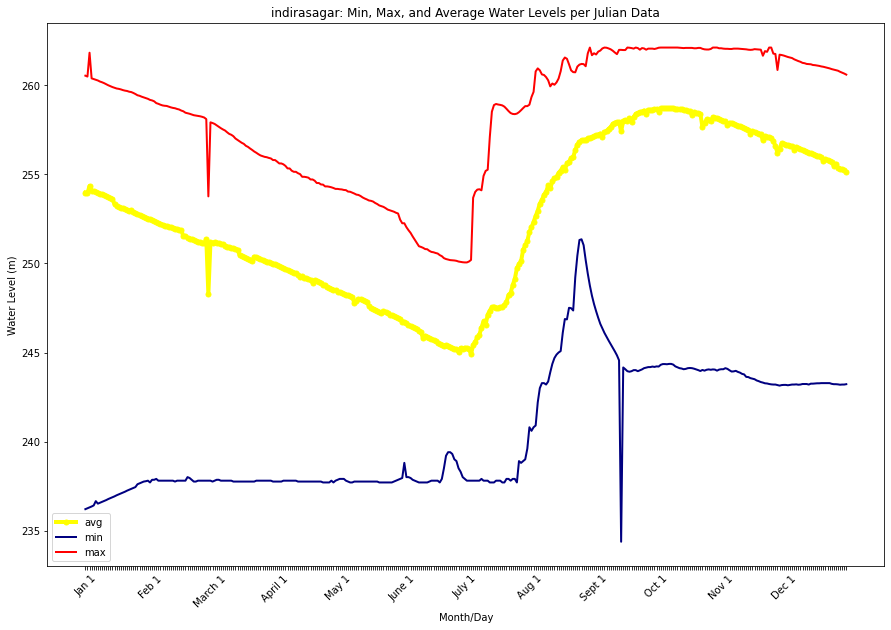

In [280]:
# Select reservoir
res = 'indirasagar'
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
print(res)
res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
# Add Day, month, year as unique columns
df_r['Day'] = df_r['Dates'].dt.day
df_r['Month'] = df_r['Dates'].dt.month
df_r['Year'] = df_r['Dates'].dt.year
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - FIND STAT PER JULIAN DAY  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Find min, max and average values per Julian date
dmin = df_r.groupby(['Day', 'Month'])['Current Year Level (m)'].min()
dmax = df_r.groupby(['Day', 'Month'])['Current Year Level (m)'].max()
dmean = df_r.groupby(['Day', 'Month'])['Current Year Level (m)'].mean()
# Add stats to 1 dataframe, sort by day of the year
daily_stats = pd.DataFrame(data = {'min': dmin, 'max': dmax, "avg": dmean}).reset_index()
daily_stats.sort_values(['Month', 'Day'], inplace = True)
# Create Julian Day #
daily_stats['JD'] = range(0,366)
# Create Date label with month and day to make it easier to read axis
daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])), axis = 1)
# Only keep the label for the 1st of every month. Else too many labels to read
daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
daily_stats['JD_Text_Clean'][daily_stats.Day > 1] = ""
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Data
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = daily_stats['JD'].tolist() # Julian day values
my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Use this color scheme if plotting 1 stat only only
#     plt.plot( x,'avg', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
# Use these color schemes if plotting all stats
plt.plot( x,'avg', data=daily_stats, marker='o', markerfacecolor='yellow', markersize=5, color='yellow', linewidth=4)
plt.plot( 'JD', 'min', data=daily_stats, marker='', color='navy', linewidth=2)
plt.plot( 'JD', 'max', data=daily_stats, marker='', color='red', linewidth=2)
# # Add legend and labels
plt.legend()
plt.title("{:s}: Min, Max, and Average Water Levels per Julian Data".format(res))
plt.xlabel('Month/Day')
plt.ylabel('Water Level (m)')
# Show plot
plt.show()



# Daily Water Levels

## Plot all daily water levels. Loop through all reservoirs

In [274]:
# Read in Reservoir Data
# Plot daily water levels
for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    res_img = os.path.join(ts_WL_range_folder, "all_dates", res + ".png") # Path to save image results # Use this option for plot with all stats
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
    # Add Day, month, year as unique columns
    df_r['Day'] = df_r['Dates'].dt.day
    df_r['Month'] = df_r['Dates'].dt.month
    df_r['Year'] = df_r['Dates'].dt.year
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN UP DATE LABEL  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    daily_stats = df_r.copy()
    daily_stats.sort_values(['Year', 'Month', 'Day'], inplace = True)
    daily_stats['JD'] = range(0,len(daily_stats)) # Create number sequence for every record
    # Create date label, only keep the 1st date per year. Else, too many labels
    daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])) + " " + str(int(x['Year'])), axis = 1)
    daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
    daily_stats['JD_Text_Clean'][(daily_stats.Day > 1) | (daily_stats.Month > 1)] = ""
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # # Data
    plt.figure(figsize=(15,10)) 
    # Create X values using Julian Day
    x = daily_stats['JD'].tolist() # Julian day values
    my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
    plt.xticks(x, my_xticks, rotation=45) # Create plot labels
    # Create plot
    plt.plot( x,'Current Year Level (m)', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
    # Add legend and labels
    plt.legend()
    plt.title("{:s}: Daily Water Levels".format(res))
    plt.xlabel('Date')
    plt.ylabel('Water Level (m)')
    # Download figure and close it
    plt.savefig(res_img, bbox_inches='tight')
    plt.close()


Bargi
Hirakud
indirasagar
Maithon
Mettur
Panchet
Pench
Rihand
Sriramsagar
Tenughat
Tilaiya


### Daily Water Level plot for select reservoir

indirasagar


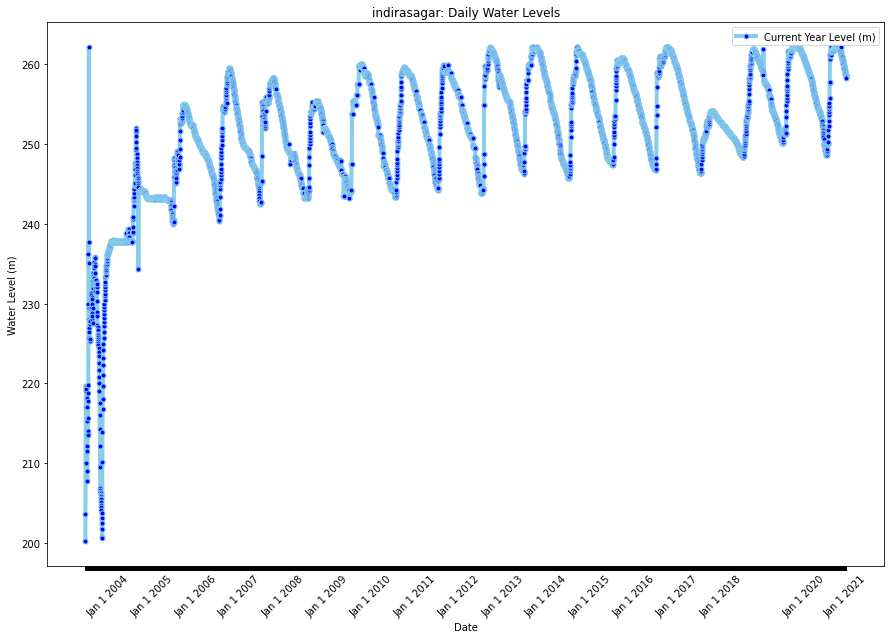

In [329]:
# Select reservoir
res = 'indirasagar'
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
print(res)
res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
res_img = os.path.join(ts_WL_range_folder, "all_dates", res + ".png") # Path to save image results # Use this option for plot with all stats
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
# Add Day, month, year as unique columns
df_r['Day'] = df_r['Dates'].dt.day
df_r['Month'] = df_r['Dates'].dt.month
df_r['Year'] = df_r['Dates'].dt.year
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN UP DATE LABEL  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
daily_stats = df_r.copy()
daily_stats.sort_values(['Year', 'Month', 'Day'], inplace = True)
daily_stats['JD'] = range(0,len(daily_stats)) # Create number sequence for every record
# Create date label, only keep the 1st date per year. Else, too many labels
daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])) + " " + str(int(x['Year'])), axis = 1)
daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
daily_stats['JD_Text_Clean'][(daily_stats.Day > 1) | (daily_stats.Month > 1)] = ""
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Data
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = daily_stats['JD'].tolist() # Julian day values
my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Create plot
plt.plot( x,'Current Year Level (m)', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
# Add legend and labels
plt.legend()
plt.title("{:s}: Daily Water Levels".format(res))
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
# Show plot
plt.show()


## Find anomalies, and plot daily water levels WITHOUT anomalies. Loop through reservoirs

In [342]:
# Read in Reservoir Data
# Remove anomalies and plot
for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    res_img = os.path.join(ts_WL_range_folder, "anomalies_removed", res + ".png") # Path to save image results # Use this option for plot with all stats
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
    # Add Day, month, year as unique columns
    df_r['Day'] = df_r['Dates'].dt.day
    df_r['Month'] = df_r['Dates'].dt.month
    df_r['Year'] = df_r['Dates'].dt.year
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - FIND ANOMALIES  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # Find anomalies
        # df_tempa = reservoir's anomalies (date used as index). 
        # df_inline = reservoir timeseries with anomalies removed
    df_tempa, df_inline = find_anomalies(df_r, res) # Runs function
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - ADD RESERVOIR ANOMALIES TO 1 DF FOR ALL RESERVOIRS  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    if res == res_list[0]:          # If this is the 1st reservoir, create new dataframe
        df_a = df_tempa.copy()
    else:                           # Else, append onto running DF
        df_a = df_a.append(df_tempa)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN UP DATE LABEL FOR PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    daily_stats = df_inline.copy()
    daily_stats.sort_values(['Year', 'Month', 'Day'], inplace = True)
    daily_stats['JD'] = range(0,len(daily_stats)) # Create number sequence for every record
    # Create date label, only keep the 1st date per year. Else, too many labels
    daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])) + " " + str(int(x['Year'])), axis = 1)
    daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
    daily_stats['JD_Text_Clean'][(daily_stats.Day > 1) | (daily_stats.Month > 1)] = ""
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # # Data
    plt.figure(figsize=(15,10)) 
    # Create X values using Julian Day
    x = daily_stats['JD'].tolist() # Julian day values
    my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
    plt.xticks(x, my_xticks, rotation=45) # Create plot labels
    # Create plot
    plt.plot( x,'Current Year Level (m)', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
    # Add legend and labels
    plt.legend()
    plt.title("{:s}: Daily Water Levels without anomalies".format(res))
    plt.xlabel('Date')
    plt.ylabel('Water Level (m)')
    # Download figure and close it
    plt.savefig(res_img, bbox_inches='tight')
    plt.close()
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SAVE ANOMALIES  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
df_a.sort_index(inplace = True)
df_a.to_csv(anomalies_path)

Bargi
Bargi
Hirakud
Hirakud
indirasagar
indirasagar
Maithon
Maithon
Mettur
Mettur
Panchet
Panchet
Pench
Pench
Rihand
Rihand
Sriramsagar
Sriramsagar
Tenughat
Tenughat
Tilaiya
Tilaiya


### Daily Water Levels without Anomalies for select Reservoir

indirasagar
indirasagar
            indirasagar
Dates                  
2003-07-01       200.25
2003-07-02       203.70
2003-07-03       210.00
2003-07-04       217.00
2003-07-05       219.10
...                 ...
2003-11-28       224.95
2003-11-29       225.70
2003-11-30       226.45
2003-12-01       227.15
2003-12-02       227.65

[95 rows x 1 columns]


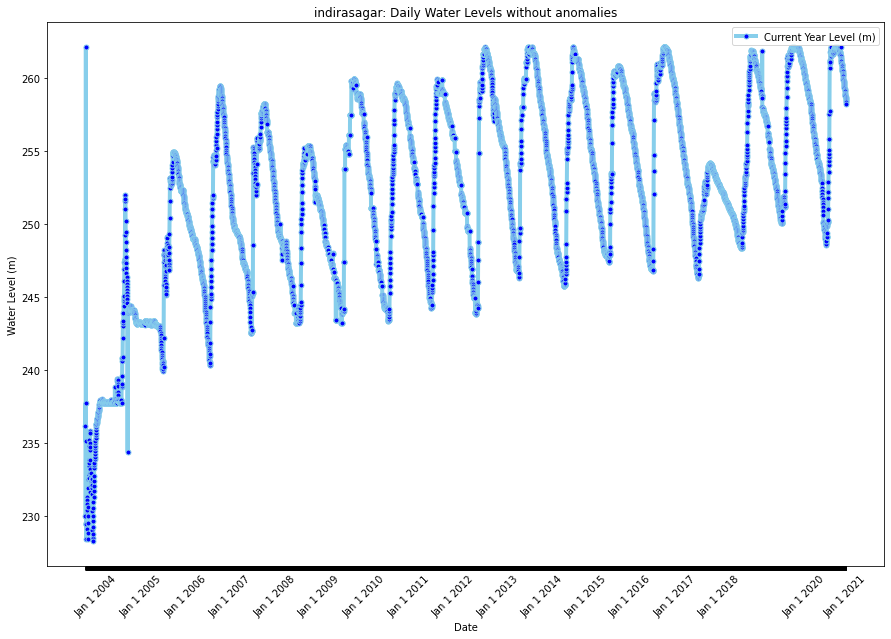

In [330]:
# Select Reservoir
res = 'indirasagar'
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
print(res)
res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
# Add Day, month, year as unique columns
df_r['Day'] = df_r['Dates'].dt.day
df_r['Month'] = df_r['Dates'].dt.month
df_r['Year'] = df_r['Dates'].dt.year
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - FIND ANOMALIES  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Find anomalies
    # df_tempa = reservoir's anomalies (date used as index). 
    # df_inline = reservoir timeseries with anomalies removed
df_tempa, df_inline = find_anomalies(df_r, res) # Runs function
print(df_tempa)
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN UP DATE LABEL FOR PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
daily_stats = df_inline.copy()
daily_stats.sort_values(['Year', 'Month', 'Day'], inplace = True)
daily_stats['JD'] = range(0,len(daily_stats)) # Create number sequence for every record
# Create date label, only keep the 1st date per year. Else, too many labels
daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])) + " " + str(int(x['Year'])), axis = 1)
daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
daily_stats['JD_Text_Clean'][(daily_stats.Day > 1) | (daily_stats.Month > 1)] = ""
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Data
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = daily_stats['JD'].tolist() # Julian day values
my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Create plot
plt.plot( x,'Current Year Level (m)', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
# Add legend and labels
plt.legend()
plt.title("{:s}: Daily Water Levels without anomalies".format(res))
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
# Show plot
plt.show()


# Time Series Analysis/ Trends

Helpers:

https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621


https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
All time series data can be broken down into four core components: the average value, a trend (i.e. an increasing mean), seasonality (i.e. a repeating cyclical pattern), and a residual (random noise). Trends and seasonality are not always present in time dependent data. <b>The residual is what’s left over after trends and seasonality are removed. Time series models assume that the data is stationary and only the residual component satisfies the conditions for stationarity.</b>

The seasonal_decompose() method can take up to six parameters. I focused on the data itself, the model type, and the frequency (period in the documentation). I used the adjusted closing prices column of the pandas dataframe where the index is a datetime object. The model type parameter can either be additive or multiplicative, this depends on if the amplitude of your data’s seasonality is level (mean) dependent. If the seasonality’s amplitude is independent of the level then you should use the additive model, and if the seasonality’s amplitude is dependent on the level then you should use the multiplicative model.


https://stackoverflow.com/questions/60017052/decompose-for-time-series-valueerror-you-must-specify-a-period-or-x-must-be/63252466:
The period parameter that is set with an integer means the number of cycles which you expect to be in the data. If you have a df with 1000 rows with a list column in it (call it df_nested), and each list with for example 100 elements, then you will have 100 elements per cycle. It is probably smart taking period = len(df_nested) (= number of cycles) in order to get the best split of seasonality and trend. If your elements per cycle vary over time, other values may be better.

Though it uses the time index (DatetimeIndex) for its x-axis, it does not require an item to hit the frequency exactly


### Long-term and seasonal trends. Loop through reservoirs

Bargi
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Hirakud
Day           datetime64[ns]
WaterLevel           float64
dtype: object
indirasagar
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Maithon
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Mettur
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Panchet
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Pench
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Rihand
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Sriramsagar
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Tenughat
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Tilaiya
Day           datetime64[ns]
WaterLevel           float64
dtype: object


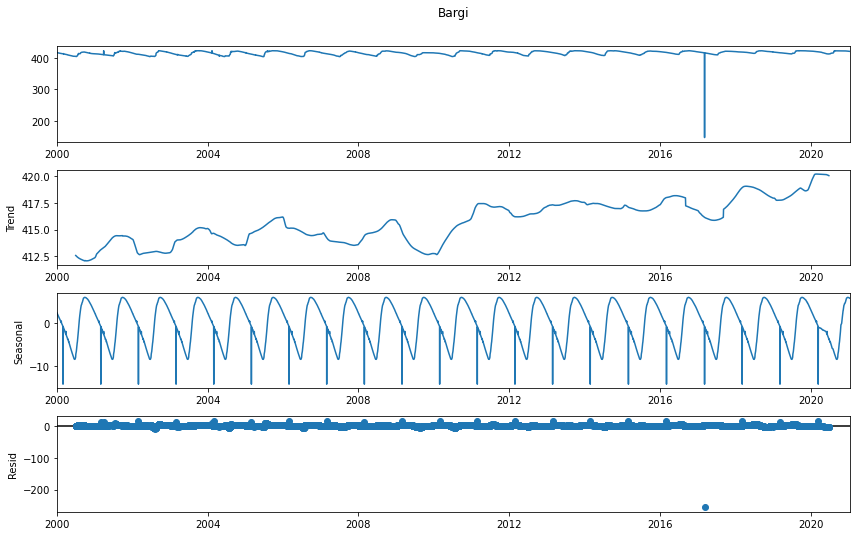

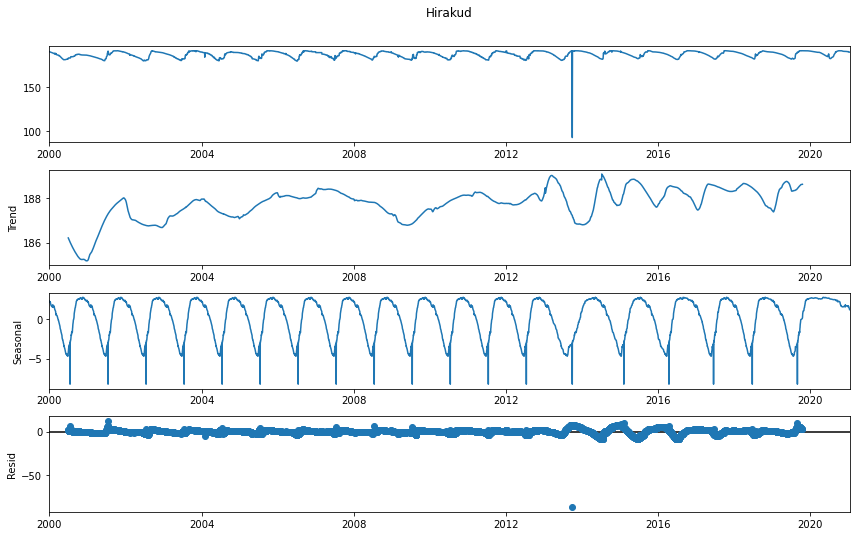

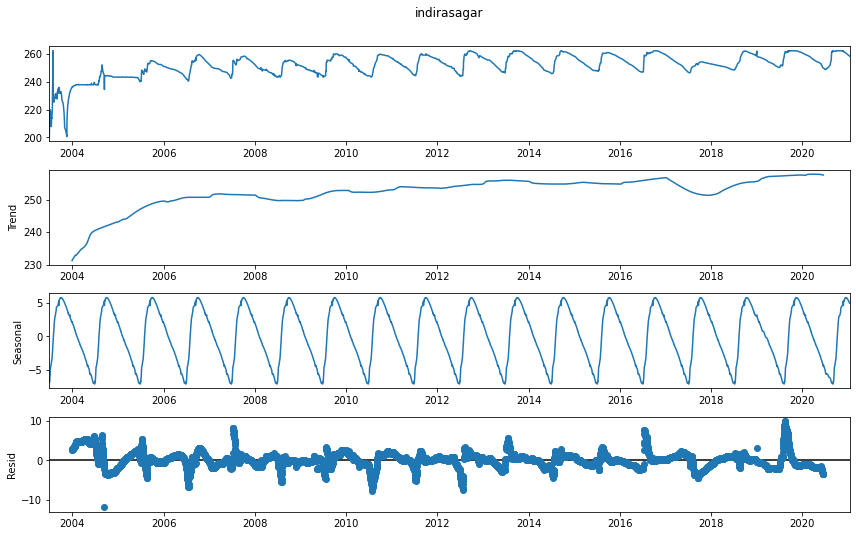

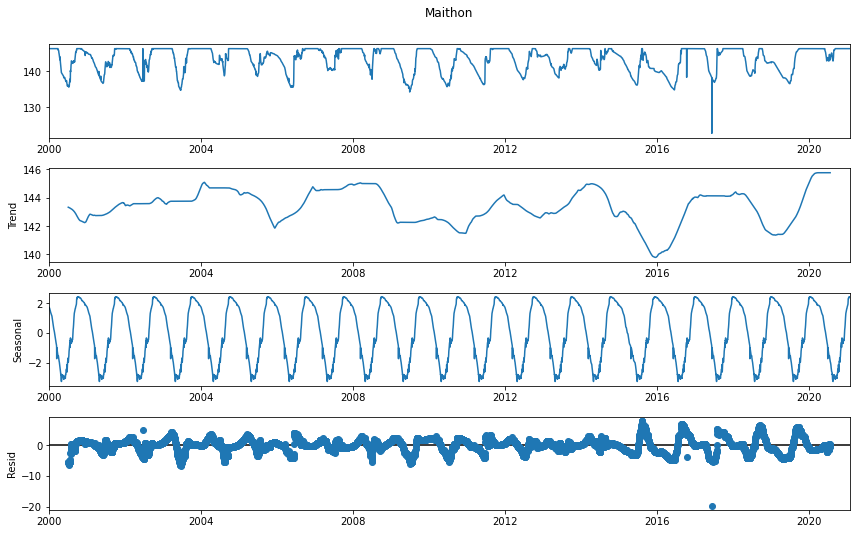

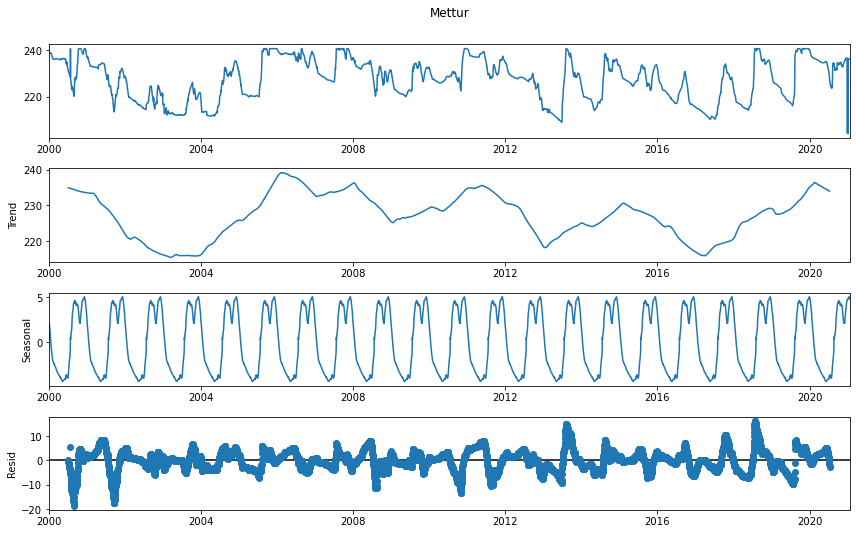

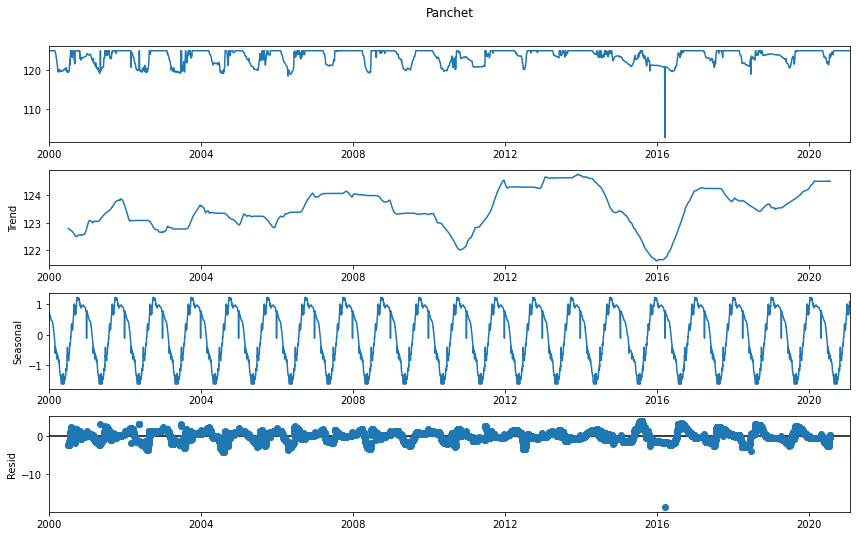

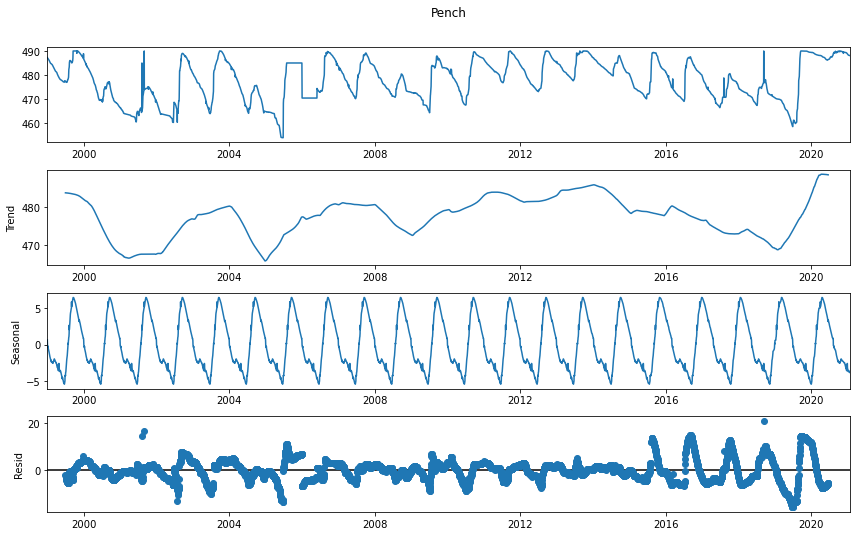

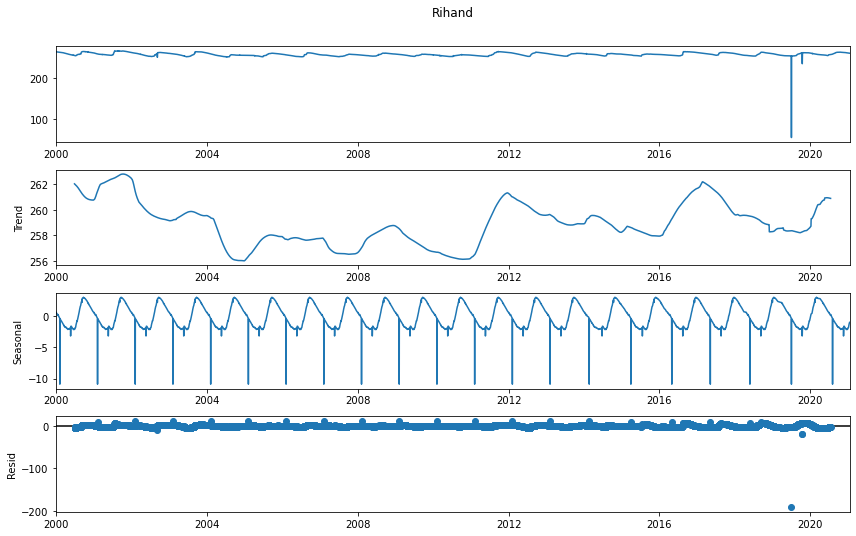

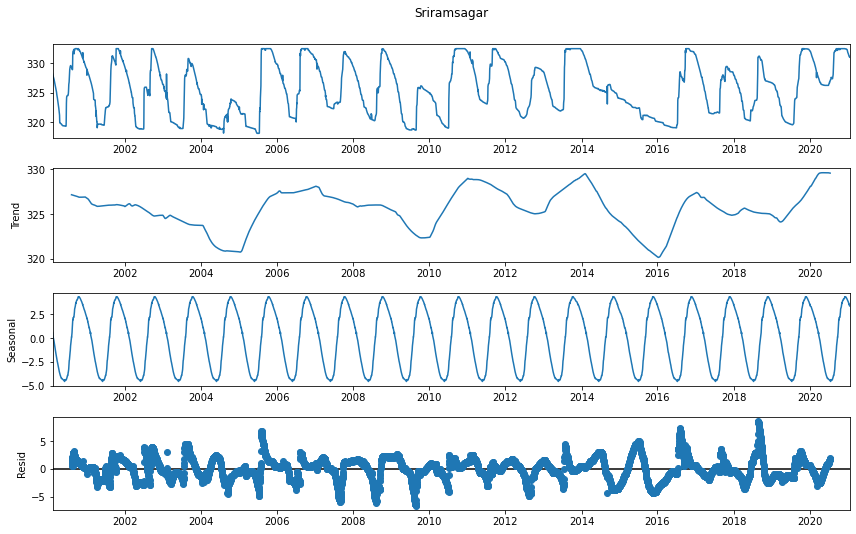

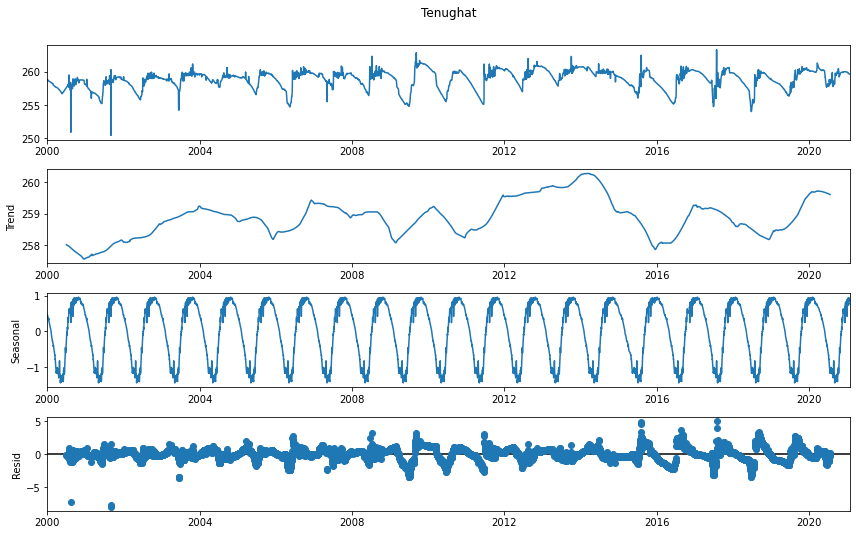

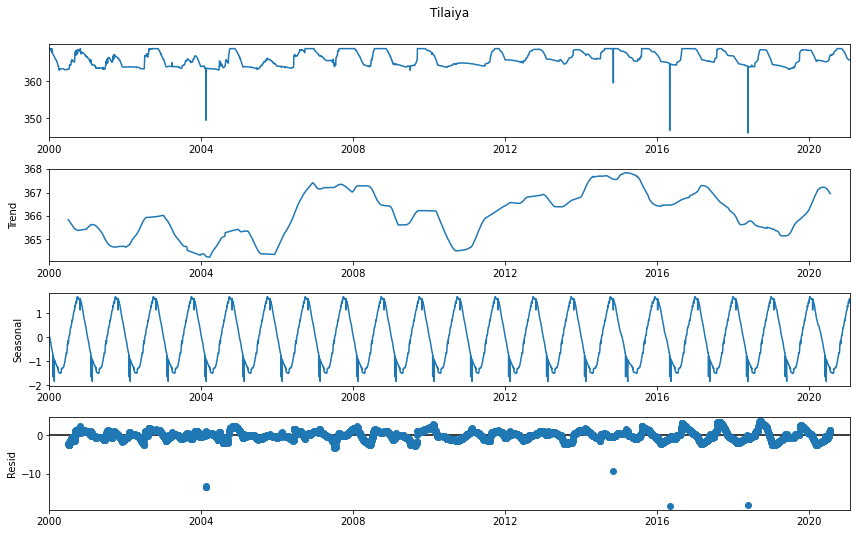

In [363]:
# Read in Reservoir Data
# Find long term and seasonal trends per reservoir. Remove anomalies first
for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    res_img = os.path.join(trends_folder, "all_dates", res + ".png") # Path to save image results
    long_img = os.path.join(trends_folder, "long_term_all_dates", res + ".png") # Path to save image results for long-term trend
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
    # Add Day, month, year as unique columns
    df_r['Day'] = df_r['Dates'].dt.day
    df_r['Month'] = df_r['Dates'].dt.month
    df_r['Year'] = df_r['Dates'].dt.year
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN UP DATE LABEL FOR PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    data_set = df_r.filter(['Dates', 'Current Year Level (m)'])
    data_set.columns = ['Day', 'WaterLevel']
    print(data_set.dtypes)
    data_set.set_index('Day', inplace = True)
    data_set.sort_index(inplace = True)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CREATE DECOMPOSITION  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
    decomposition = sm.tsa.seasonal_decompose(data_set, model = 'additive', period = 365)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - DECOMPOSITION PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # # Data
    plt.rc('figure', figsize=(12, 7))
    decomposition.plot()
    plt.title(res, pad = 400)
    plt.savefig(res_img)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - LONGTERM PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
    fig, ax = plt.subplots()
    ax.grid(True)
    year = mdates.YearLocator(month=1)
    month = mdates.MonthLocator(interval=3)
    year_format = mdates.DateFormatter('%Y')
    month_format = mdates.DateFormatter('%m')
    ax.xaxis.set_minor_locator(month)
    ax.xaxis.grid(True, which = 'minor')
    ax.xaxis.set_major_locator(year)
    ax.xaxis.set_major_formatter(year_format)
    plt.plot(data_set.index, data_set['WaterLevel'], c='blue')
    plt.plot(decomposition.trend.index, decomposition.trend, c='red')
    plt.savefig(long_img, bbox_inches='tight')
    plt.close()
    


### Long-term and seasonal trends without Anomalies. Loop through reservoirs

Bargi
Bargi
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Hirakud
Hirakud
Day           datetime64[ns]
WaterLevel           float64
dtype: object
indirasagar
indirasagar
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Maithon
Maithon
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Mettur
Mettur
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Panchet
Panchet
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Pench
Pench
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Rihand
Rihand
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Sriramsagar
Sriramsagar
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Tenughat
Tenughat
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Tilaiya
Tilaiya
Day           datetime64[ns]
WaterLevel           float64
dtype: object


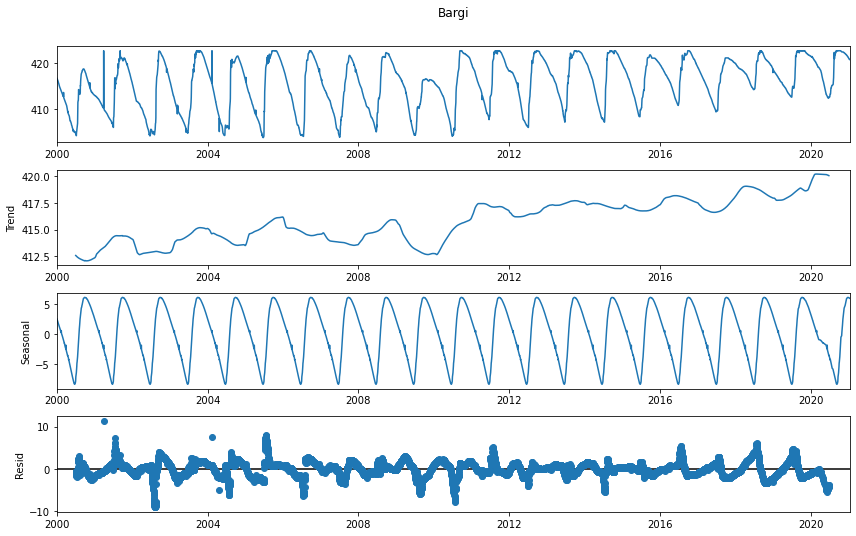

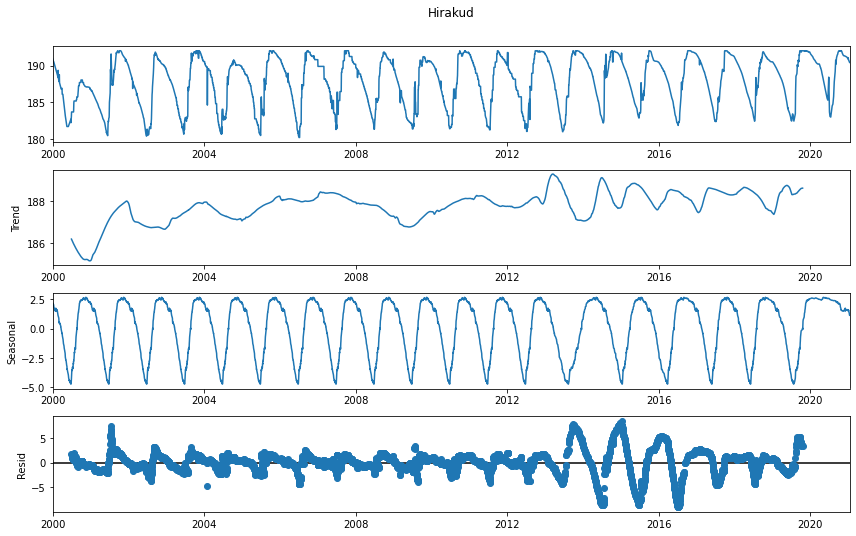

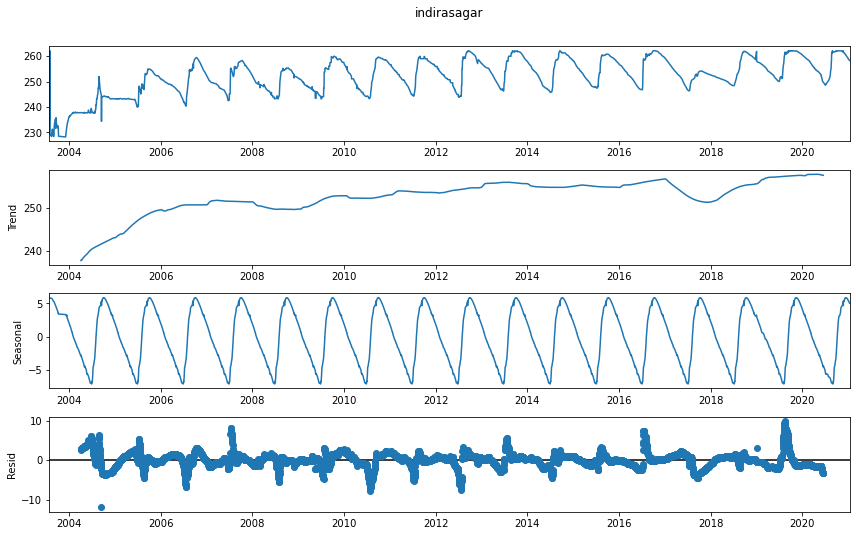

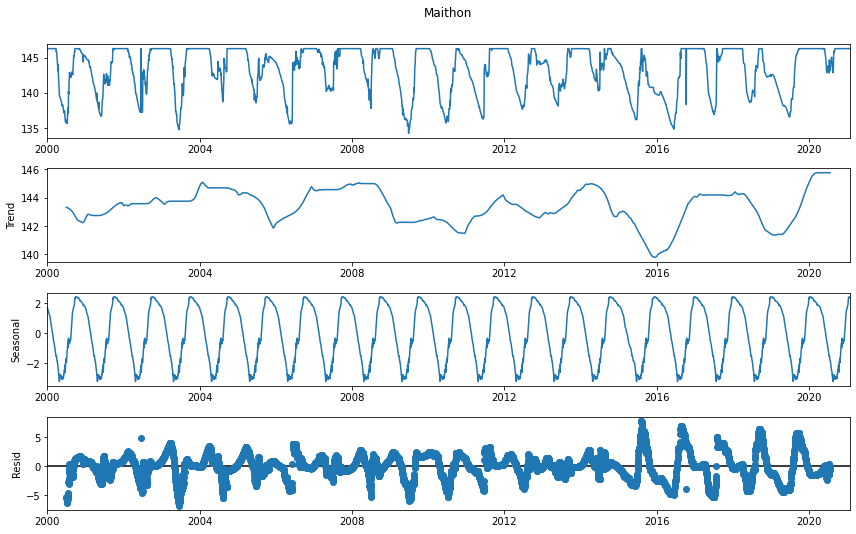

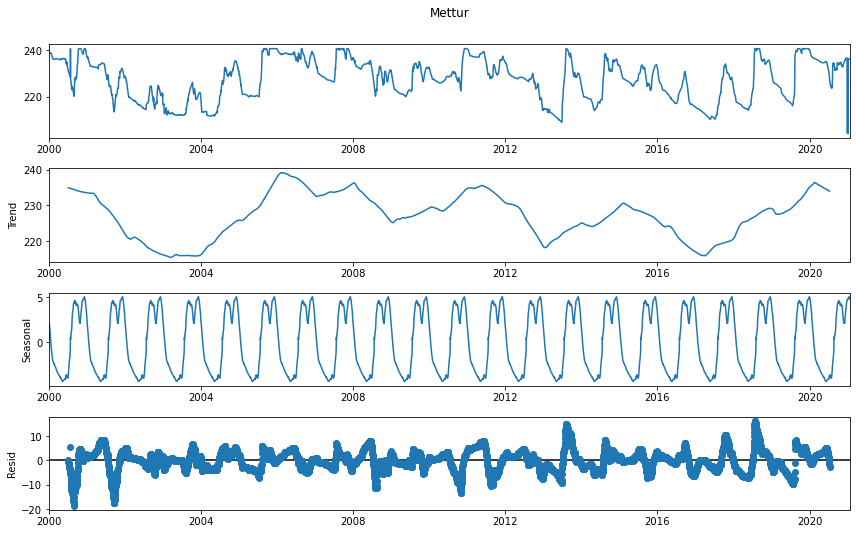

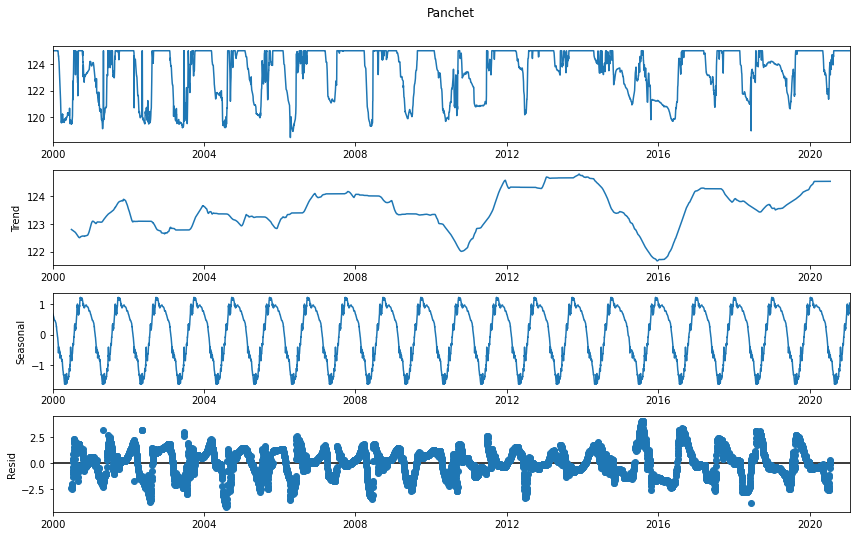

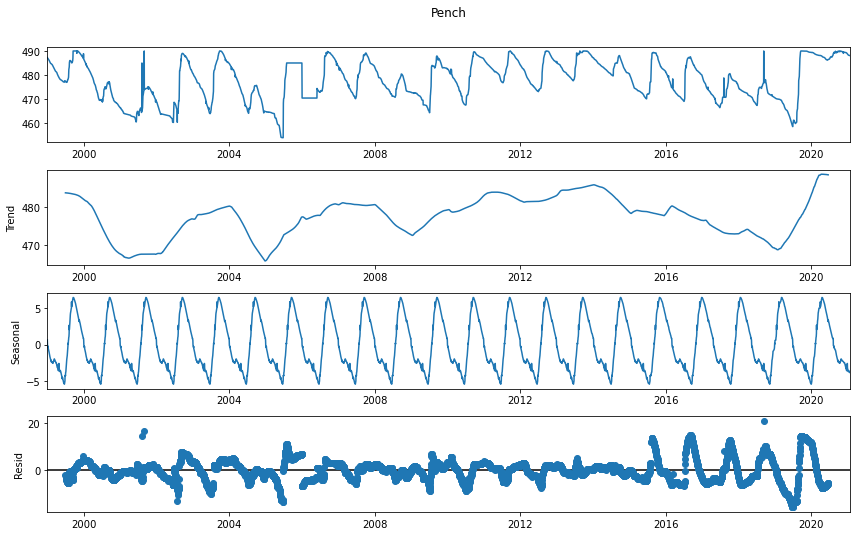

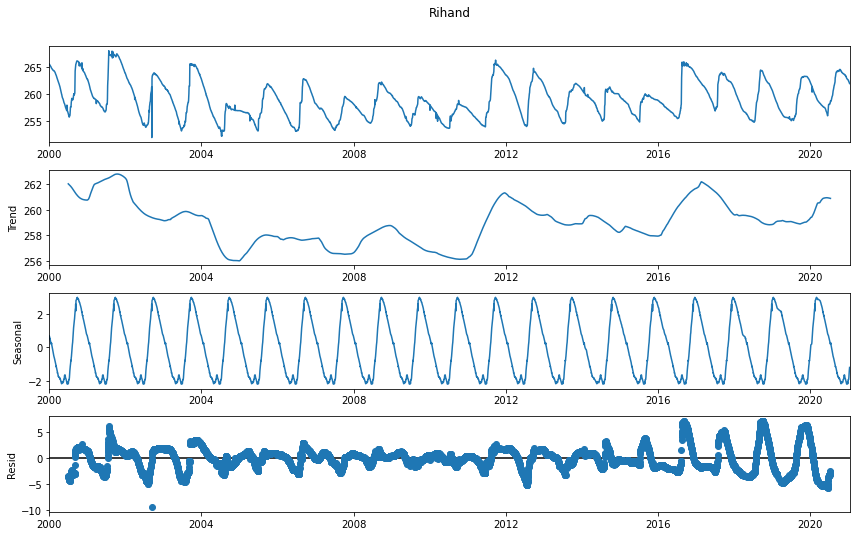

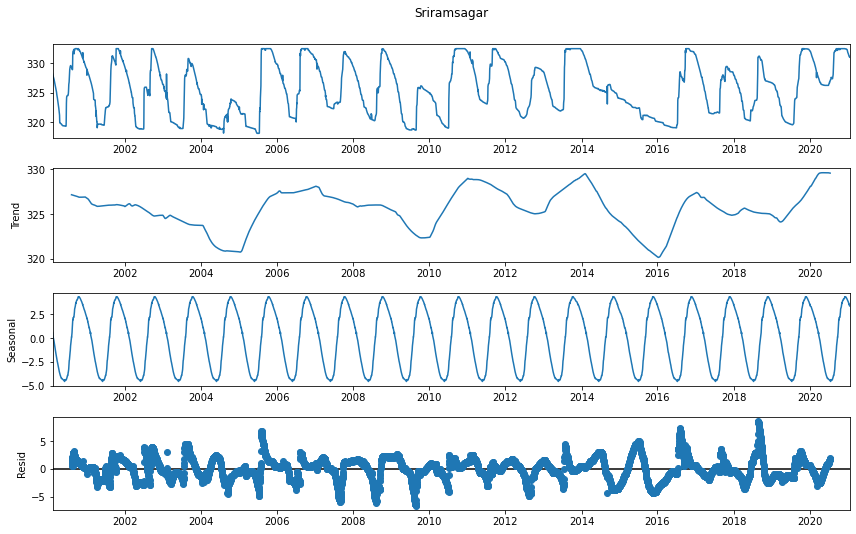

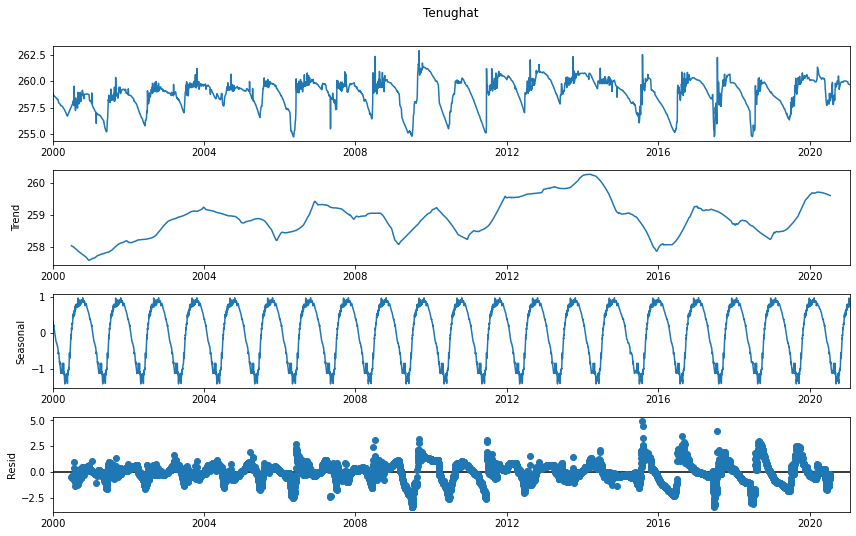

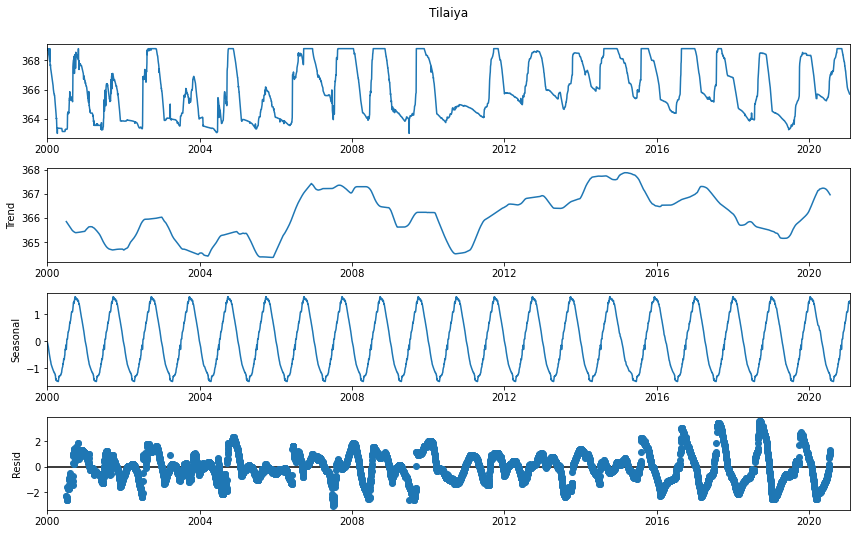

In [350]:
# Read in Reservoir Data
# Find long term and seasonal trends per reservoir. Remove anomalies first
for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    res_img = os.path.join(trends_folder, "anomalies_removed", res + ".png") # Path to save image results
    long_img = os.path.join(trends_folder, "long_term_anomalies_removed", res + ".png") # Path to save image results for long-term trend
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
    # Add Day, month, year as unique columns
    df_r['Day'] = df_r['Dates'].dt.day
    df_r['Month'] = df_r['Dates'].dt.month
    df_r['Year'] = df_r['Dates'].dt.year
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - FIND ANOMALIES  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # Find anomalies
        # df_tempa = reservoir's anomalies (date used as index). 
        # df_inline = reservoir timeseries with anomalies removed
    df_tempa, df_inline = find_anomalies(df_r, res) # Runs function
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN UP DATE LABEL FOR PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    data_set = df_inline.filter(['Dates', 'Current Year Level (m)'])
    data_set.columns = ['Day', 'WaterLevel']
    print(data_set.dtypes)
    data_set.set_index('Day', inplace = True)
    data_set.sort_index(inplace = True)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CREATE DECOMPOSITION  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
    decomposition = sm.tsa.seasonal_decompose(data_set, model = 'additive', period = 365)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - DECOMPOSITION PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # # Data
    plt.rc('figure', figsize=(12, 7))
    decomposition.plot()
    plt.title(res, pad = 400)
    plt.savefig(res_img)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - LONGTERM PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
    fig, ax = plt.subplots()
    ax.grid(True)
    year = mdates.YearLocator(month=1)
    month = mdates.MonthLocator(interval=3)
    year_format = mdates.DateFormatter('%Y')
    month_format = mdates.DateFormatter('%m')
    ax.xaxis.set_minor_locator(month)
    ax.xaxis.grid(True, which = 'minor')
    ax.xaxis.set_major_locator(year)
    ax.xaxis.set_major_formatter(year_format)
    plt.plot(data_set.index, data_set['WaterLevel'], c='blue')
    plt.plot(decomposition.trend.index, decomposition.trend, c='red')
    plt.savefig(long_img, bbox_inches='tight')
    plt.close()
    


Rihand
Day           datetime64[ns]
WaterLevel           float64
dtype: object


Text(0.5, 1.0, 'Rihand')

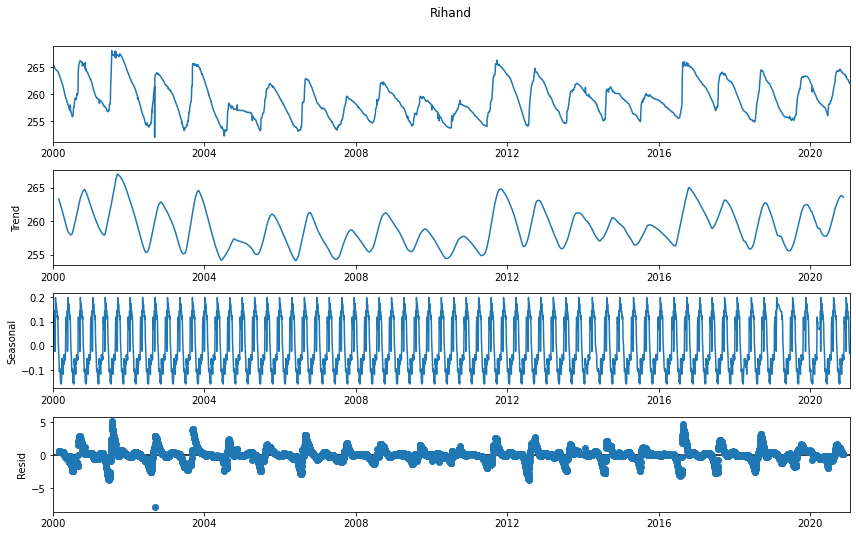

In [418]:
res = 'Rihand'
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
print(res)
res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
# Add Day, month, year as unique columns
df_r['Day'] = df_r['Dates'].dt.day
df_r['Month'] = df_r['Dates'].dt.month
df_r['Year'] = df_r['Dates'].dt.year
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - FIND ANOMALIES  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Find anomalies
    # df_tempa = reservoir's anomalies (date used as index). 
    # df_inline = reservoir timeseries with anomalies removed
df_tempa, df_inline = find_anomalies(df_r, res) # Runs function
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CLEAN UP DATE LABEL FOR PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
data_set = df_inline.filter(['Dates', 'Current Year Level (m)'])
data_set.columns = ['Day', 'WaterLevel']
print(data_set.dtypes)
data_set.set_index('Day', inplace = True)
data_set.sort_index(inplace = True)
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CREATE DECOMPOSITION  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
decomposition = sm.tsa.seasonal_decompose(data_set, model = 'additive', period = 120)
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - DECOMPOSITION PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Data
plt.rc('figure', figsize=(12, 7))
decomposition.plot()
plt.title(res, pad = 400)



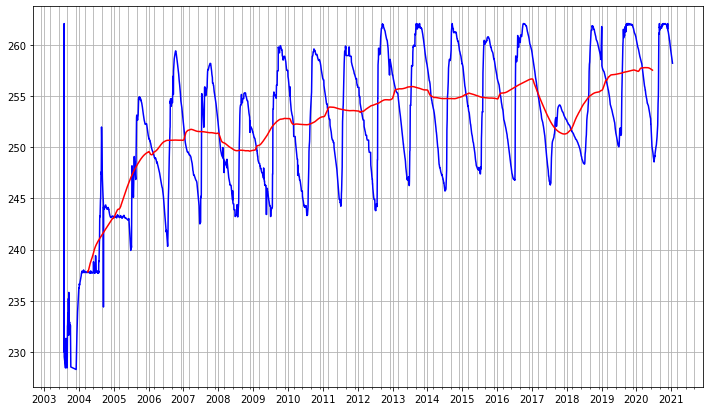

In [365]:
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - LONGTERM PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
fig, ax = plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(data_set.index, data_set['WaterLevel'], c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')


## Find p-values for different trials

In [402]:
df_add = pd.DataFrame(index = res_list, columns = [1, 30, 120, 365])
df_mult = pd.DataFrame(index = res_list, columns = [1, 30, 120, 365])
df_add['decomtype'] = 'additive'
df_mult['decomtype'] = 'multiplicative'
# Read in Reservoir Data
# Find long term and seasonal trends per reservoir. Remove anomalies first
for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - SET FILE LOCATIONS PER ROUND  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN DATA  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r['Dates'] = pd.to_datetime(df_r.Dates) # Set date as date format
    # Add Day, month, year as unique columns
    df_r['Day'] = df_r['Dates'].dt.day
    df_r['Month'] = df_r['Dates'].dt.month
    df_r['Year'] = df_r['Dates'].dt.year  
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - FIND ANOMALIES  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    # Find anomalies
        # df_tempa = reservoir's anomalies (date used as index). 
        # df_inline = reservoir timeseries with anomalies removed
    df_tempa, df_inline = find_anomalies(df_r, res) # Runs function
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CLEAN UP DATE LABEL FOR PLOT  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    data_set = df_inline.filter(['Dates', 'Current Year Level (m)'])
    data_set.columns = ['Day', 'WaterLevel']
    print(data_set.dtypes)
    data_set.set_index('Day', inplace = True)
    data_set.sort_index(inplace = True)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - LOOP THROUGH DECOMPOSITION TRIALS  - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -      
    for p in [1, 30, 120, 365]:
        decomposition_add = sm.tsa.seasonal_decompose(data_set, model = 'additive', period = p)
        decomposition_mult = sm.tsa.seasonal_decompose(data_set, model = 'multiplicative', period = p)
        
        df_add.loc[res, p] = stationarity_check(decomposition_add.resid.dropna())
        df_mult.loc[res, p] = stationarity_check(decomposition_mult.resid.dropna())
        
df_all = df_add.append(df_mult).reset_index()
df_all.sort_values(['index', 'decomtype'], inplace = True)

Bargi
Bargi
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Hirakud
Hirakud
Day           datetime64[ns]
WaterLevel           float64
dtype: object
indirasagar
indirasagar
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Maithon
Maithon
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Mettur
Mettur
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Panchet
Panchet
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Pench
Pench
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Rihand
Rihand
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Sriramsagar
Sriramsagar
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Tenughat
Tenughat
Day           datetime64[ns]
WaterLevel           float64
dtype: object
Tilaiya
Tilaiya
Day           datetime64[ns]
WaterLevel           float64
dtype: object
